In [1]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Importing & Parsing the csv

In [3]:

path_to_file='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_data.csv'
path_to_events='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_event.csv'
path_to_montage_glob='/media/venkatesh/venky/IMT-Study/2020/Stage/Code S4B2/GSN_HydroCel_129_hbn.sfp'
path_to_montage_ses='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_chanlocs.csv'
fs=500
chans_glob=mne.channels.read_custom_montage(fname='GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated

# channels to exclude because noisy (Nentwich paper)
#ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
ch_list=[]

def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage='GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data=np.loadtxt(path_to_file,delimiter=',')
    chans=pd.read_csv(path_to_montage_ses,sep=',',header=None)
    ch_names=list(chans.values[1:,0])

    types=['eeg']*len(ch_names)
    info=mne.create_info(ch_names,sfreq=fs,ch_types=types)
    raw=mne.io.RawArray(data, info)

    # set standard montage
    if montage:
        raw.set_montage(montage)

    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep=r'\s*,\s*', header=None, engine='python')
        values = raw_events[0].to_list()
    
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']

        samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype=int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype=int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis=0).astype('int')
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep=mne.pick_channels(raw.ch_names,include=raw.ch_names,exclude=ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    return raw


raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage='GSN-HydroCel-129')


Creating RawArray with float64 data, n_channels=111, n_times=176386
    Range : 0 ... 176385 =      0.000 ...   352.770 secs
Ready.


# Plotting the Electrodes

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


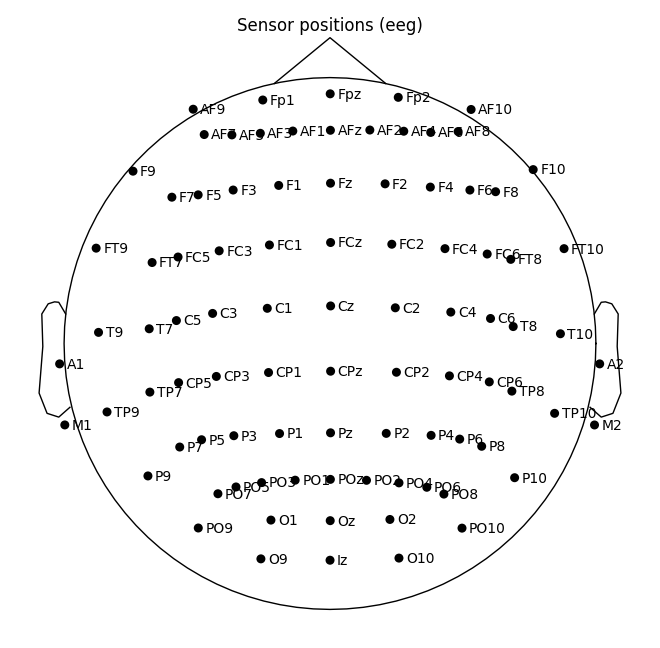

In [4]:
%matplotlib qt
montage_1020 = mne.channels.make_standard_montage("standard_1020")
#montage_hydro = mne.channels.make_standard_montage("GSN-HydroCel-129") #without the removal of the bad electrodes

# for an easier comarison, plotting in a separate windows. However only the 2nd plot is shown inside the notebook
raw.plot_sensors(show_names=True,title='HydroCel')

montage_1020.plot()

# Epoch (ing) the raw data

In [24]:
epochs = mne.Epochs(raw, events, [90,20,30,1], tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)
epochs.info

Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 551 original time points ...
1 bad epochs dropped


<ipython-input-24-90ef0588d55b>:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, [90,20,30,1], tmin=-0.1, tmax=1,


<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 111 EEG
 custom_ref_applied: False
 dig: 114 items (3 Cardinal, 111 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 111
 projs: []
 sfreq: 500.0 Hz
>

In [25]:
# The normalization is needed for the time-domain raw data's plot. StandardScaler is considered for the same and
# needs epoch array as an input. 

# But the epochs array does not seem to work right. Something is not as expected.
mne.EpochsArray(data = raw,info = raw.info,events=events)

ValueError: All picks must be < n_channels (111), got 111

# Topo Plot

Effective window size : 4.096 (s)


/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/raw.py:1005: RuntimeWarning: divide by zero encountered in log10
  psds = 10 * np.log10(psds)
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:481: RuntimeWarning: invalid value encountered in multiply
  bn.x_t + bn.x_s * times_, bn.y_t + bn.y_s * data_[ch_idx],
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - b

/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.y_s * ylim[0]
/home/venkatesh/.local/lib/python3.8/site-packages/mne/viz/topo.py:296: RuntimeWarning: invalid value encountered in double_scalars
  bn.y_t = pos[1] - bn.

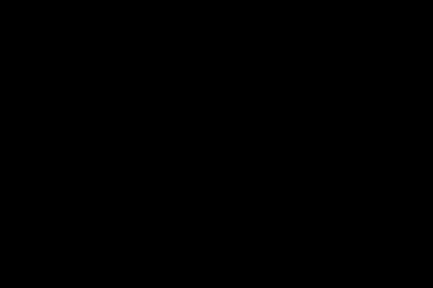

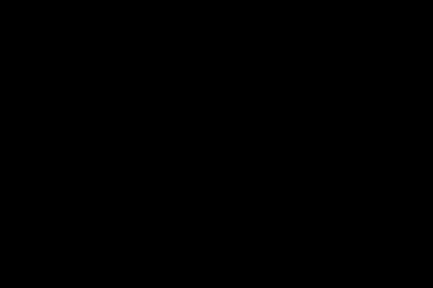

In [5]:
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.116.7379&rep=rep1&type=pdf

# It shows a giant black plot...
raw.plot_psd_topo(color='blue')


In [5]:

# kind = kinda standard which has 3D coordinates for 128 electrodes and 3 default things
montage_plot = mne.channels.make_standard_montage(kind= "GSN-HydroCel-129")  
# Note: By default, the 3d plots displayed here does not show the 3rd axis, thus require a
# a package called qt, can be called with %matplotlib qt
%matplotlib qt

fig = montage_plot.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)


Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


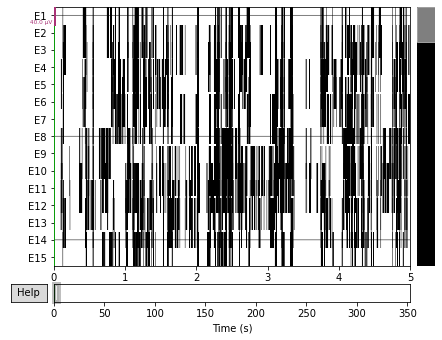

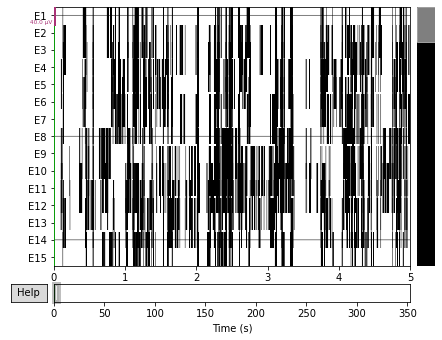

In [23]:
# Signal in Time domain
mne.viz.plot_raw(raw,n_channels=15,duration =5) # refinement is needed, weird results


# Plotting events

In [29]:
mne.viz.plot_events(events[:-1], sfreq=raw.info['sfreq'])
#The last event 20 falls is on 174120 and the last sample is 176386. That's just 4 seconds before the end of the EEG

array([174120,      0,     20])

Effective window size : 4.096 (s)


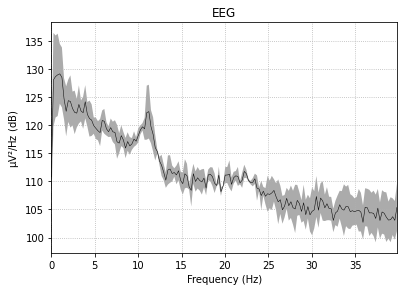

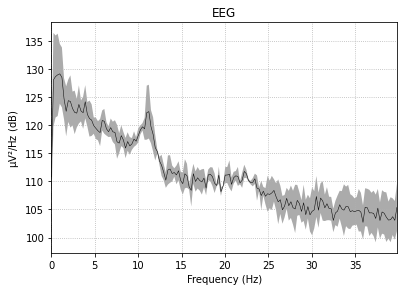

In [19]:
raw.plot_psd(tmax=70,fmax=40,picks=['E4','E36','E49','E58','E96','E100'],area_mode='std',average=True)

Effective window size : 4.096 (s)


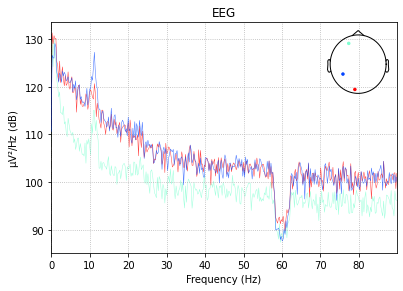

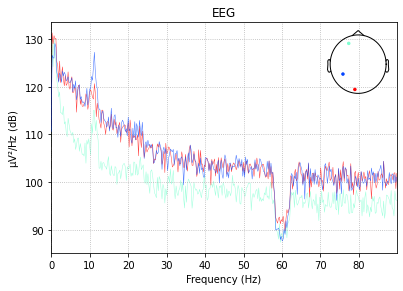

In [20]:
mne.viz.plot_raw_psd(raw,tmax=40,fmax=90,picks=['E74','E51','E23'])

Using up to 1763 segments
Number of samples used : 176300
[done]
Computing rank from covariance with rank=None
    Using tolerance 0.57 (2.2e-16 eps * 111 dim * 2.3e+13  max singular value)
    Estimated rank (eeg): 105
    EEG: rank 105 computed from 111 data channels with 0 projectors


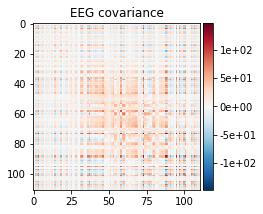

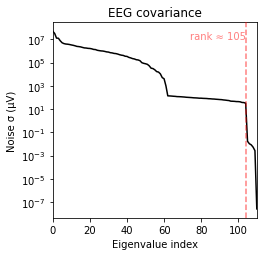

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [21]:
# Plotting covariance
mne.viz.plot_cov(mne.compute_raw_covariance(raw),raw.info) 